In [1]:
import numpy as np 
import pandas as pd 
import random
import glob

import torch
import torch.nn as nn
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

import os
import cv2
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from sklearn.model_selection import train_test_split


os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
torch.cuda.empty_cache()
torch.cuda.is_available()

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [2]:
# Path to all data
DATA_PATH = "./dataset/lgg-mri-segmentation/kaggle_3m/"
MODEL_SAVE_PATH = "./model_weight/unet.pth"

# File path line length images for later sorting
BASE_LEN = 85 
END_IMG_LEN = 4 
END_MASK_LEN = 9 

# img size
IMG_SIZE = 128

# Brain_Mri_dataset

In [3]:
class BrainDataset(Dataset):
    def __init__(self, root_path, test=False):

        self.root_path = root_path

        # Get All the images and masks
        data_map = []
        for sub_dir_path in glob.glob(root_path+"*"):
            if os.path.isdir(sub_dir_path):
                dirname = sub_dir_path.split("/")[-1]
                for filename in os.listdir(sub_dir_path):
                    image_path = sub_dir_path + "/" + filename
                    data_map.extend([dirname, image_path])
            else:
                print("This is not a dir:", sub_dir_path)
                
                
        df = pd.DataFrame({"dirname" : data_map[::2],
                        "path" : data_map[1::2]})
        df.head()

        # Masks/Not masks
        df_imgs = df[~df['path'].str.contains("mask")]
        df_masks = df[df['path'].str.contains("mask")]

        # Data sorting
        self.images = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
        self.masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

        # Sorting check
        idx = random.randint(0, len(self.images)-1)
        print("Random Sample\nPath to the Image:", self.images[idx], "\nPath to the Mask:", self.masks[idx])

        # Dataframe creation
        self.df = pd.DataFrame({"patient" : [s.split("\\")[1].split("/")[0] for s in self.images],
                        "image_path" : self.images,
                        "mask_path": self.masks})
        
        self.df["diagnosis"] = self.df["mask_path"].apply(lambda x: 1 if np.max(cv2.imread(x)) > 0 else 0)
        
        train, test = train_test_split(self.df, test_size=0.03)

        self.df = train
        self.test = test

        self.images = self.df["image_path"].values
        self.masks = self.df["mask_path"].values
    
    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert("RGB")
        mask = Image.open(self.masks[index]).convert("L")
        
        img, mask = self._tranforms(img, mask)

        return img, mask
    
    def __len__(self):
        return len(self.images)
    
    def _tranforms(self, image, mask):

        image = transforms.functional.resize(image, (IMG_SIZE,IMG_SIZE))
        mask = transforms.functional.resize(mask, (IMG_SIZE,IMG_SIZE))

        if random.random() > 0.5:
            image = transforms.functional.hflip(image)
            mask = transforms.functional.hflip(mask)

        if random.random() > 0.5:
            image = transforms.functional.vflip(image)
            mask = transforms.functional.vflip(mask)

        rotation = random.randint(-180, 180)
        image = transforms.functional.rotate(image, rotation)
        mask = transforms.functional.rotate(mask, rotation)

        return transforms.ToTensor()(image), transforms.ToTensor()(mask)
    
    def get_df(self):
        return self.df
    
    def get_test_df(self):
        return self.test
            

In [4]:
dataset = BrainDataset(DATA_PATH)
df = dataset.get_df()
df

This is not a dir: ./dataset/lgg-mri-segmentation/kaggle_3m\data.csv
This is not a dir: ./dataset/lgg-mri-segmentation/kaggle_3m\README.md
Random Sample
Path to the Image: ./dataset/lgg-mri-segmentation/kaggle_3m\TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_3.tif 
Path to the Mask: ./dataset/lgg-mri-segmentation/kaggle_3m\TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_3_mask.tif


,patient,image_path,mask_path,diagnosis
2656,TCGA_DU_7298_19910324,./dataset/lgg-mri-segmentation/kaggle_3m\TCGA_...,./dataset/lgg-mri-segmentation/kaggle_3m\TCGA_...,0
748,TCGA_HT_7694_19950404,./dataset/lgg-mri-segmentation/kaggle_3m\TCGA_...,./dataset/lgg-mri-segmentation/kaggle_3m\TCGA_...,1
411,TCGA_HT_7616_19940813,./dataset/lgg-mri-segmentation/kaggle_3m\TCGA_...,./dataset/lgg-mri-segmentation/kaggle_3m\TCGA_...,0
1864,TCGA_HT_8114_19981030,./dataset/lgg-mri-segmentation/kaggle_3m\TCGA_...,./dataset/lgg-mri-segmentation/kaggle_3m\TCGA_...,1
2373,TCGA_HT_7860_19960513,./dataset/lgg-mri-segmentation/kaggle_3m\TCGA_...,./dataset/lgg-mri-segmentation/kaggle_3m\TCGA_...,0
...,...,...,...,...
753,TCGA_HT_7877_19980917,./dataset/lgg-mri-segmentation/kaggle_3m\TCGA_...,./dataset/lgg-mri-segmentation/kaggle_3m\TCGA_...,0
1093,TCGA_HT_8113_19930809,./dataset/lgg-mri-segmentation/kaggle_3m\TCGA_...,./dataset/lgg-mri-segmentation/kaggle_3m\TCGA_...,0
446,TCGA_CS_5396_20010302,./dataset/lgg-mri-segmentation/kaggle_3m\TCGA_...,./dataset/lgg-mri-segmentation/kaggle_3m\TCGA_...,0
176,TCGA_FG_6690_20020226,./dataset/lgg-mri-segmentation/kaggle_3m\TCGA_...,./dataset/lgg-mri-segmentation/kaggle_3m\TCGA_...,0


### Data Distribution

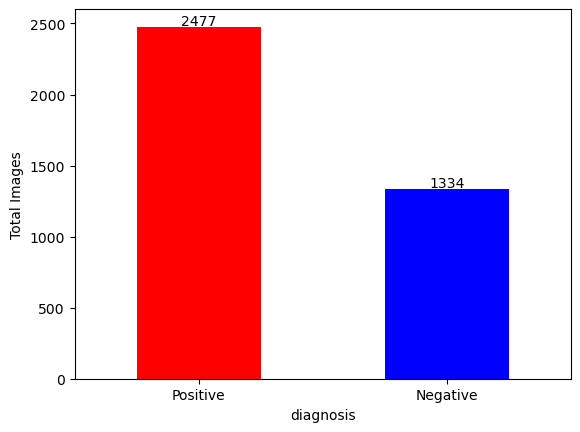

In [5]:
dist_plot = df.diagnosis.value_counts().plot(kind="bar", stacked=True, color=["red","blue"])

dist_plot.set_xticklabels(["Positive", "Negative"], rotation=0)
dist_plot.set_ylabel('Total Images')

for i, row in enumerate(df.diagnosis.value_counts()):
    dist_plot.annotate(row, xy=(i, row + 12), ha="center")

Text(0.5, 1.005, 'Distribution of data grouped by patient and diagnosis')

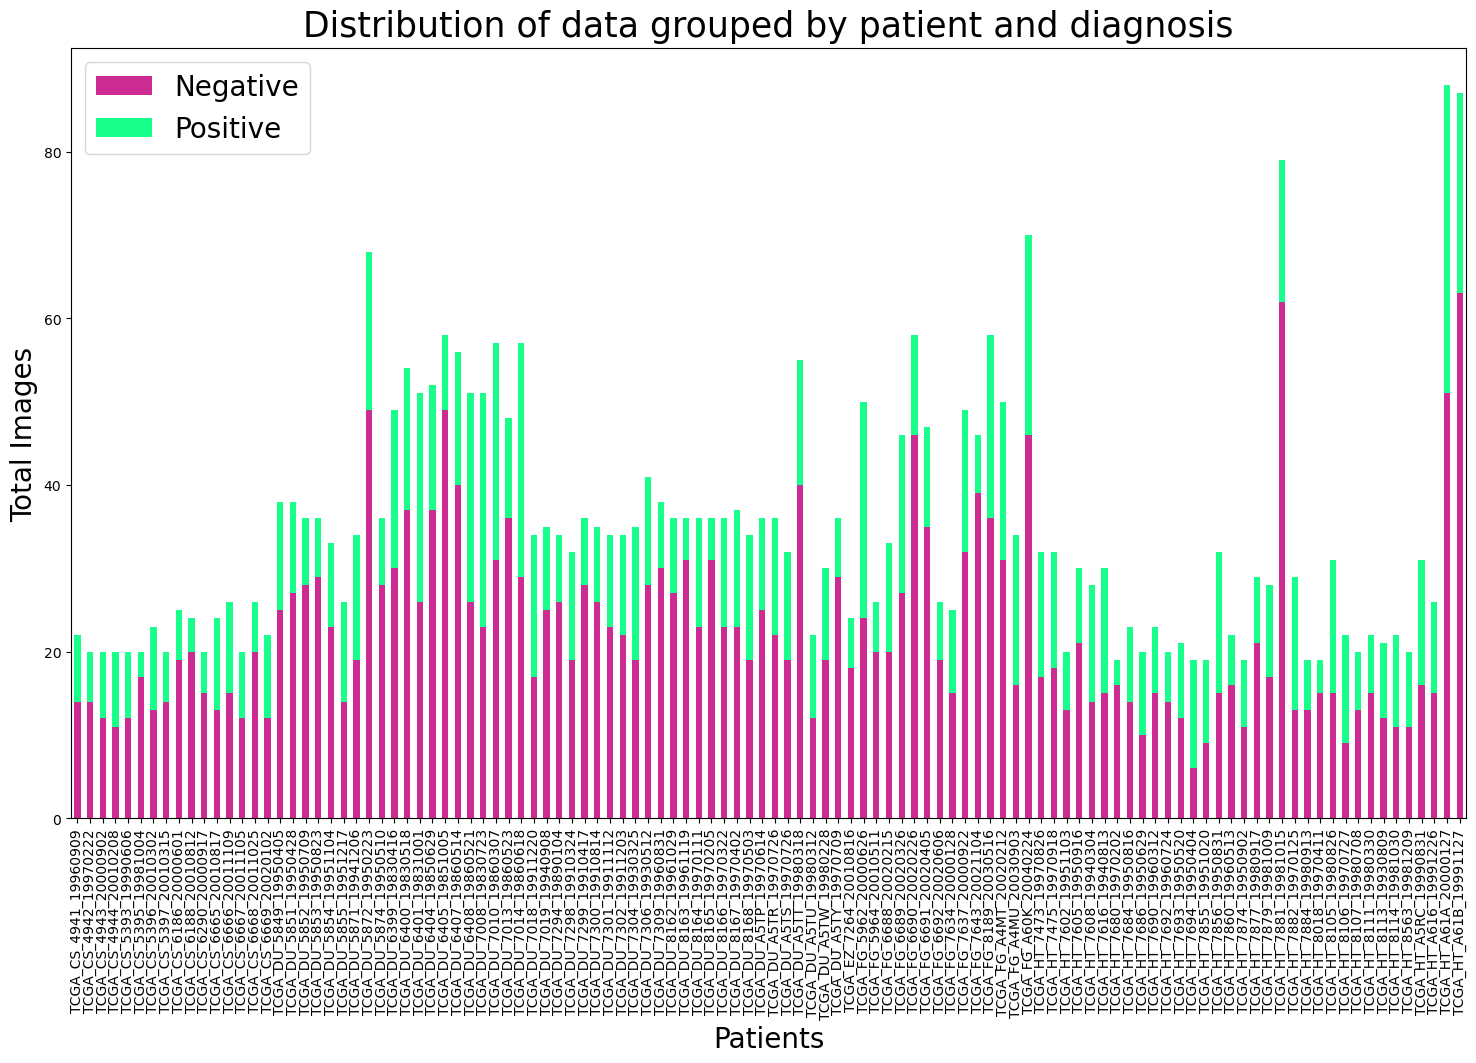

In [6]:
# Data
patients_by_diagnosis = df.groupby(['patient', 'diagnosis'])['diagnosis'].size().unstack().fillna(0)
patients_by_diagnosis.columns = ["Negative", "Positive"]

# Plot
ax = patients_by_diagnosis.plot(kind='bar',stacked=True,
                                figsize=(18, 10),
                                color=["mediumvioletred", "springgreen"], 
                                alpha=0.9)
ax.legend(fontsize=20)
ax.set_xlabel('Patients',fontsize = 20)
ax.set_ylabel('Total Images', fontsize = 20)
ax.set_title("Distribution of data grouped by patient and diagnosis",fontsize = 25, y=1.005)

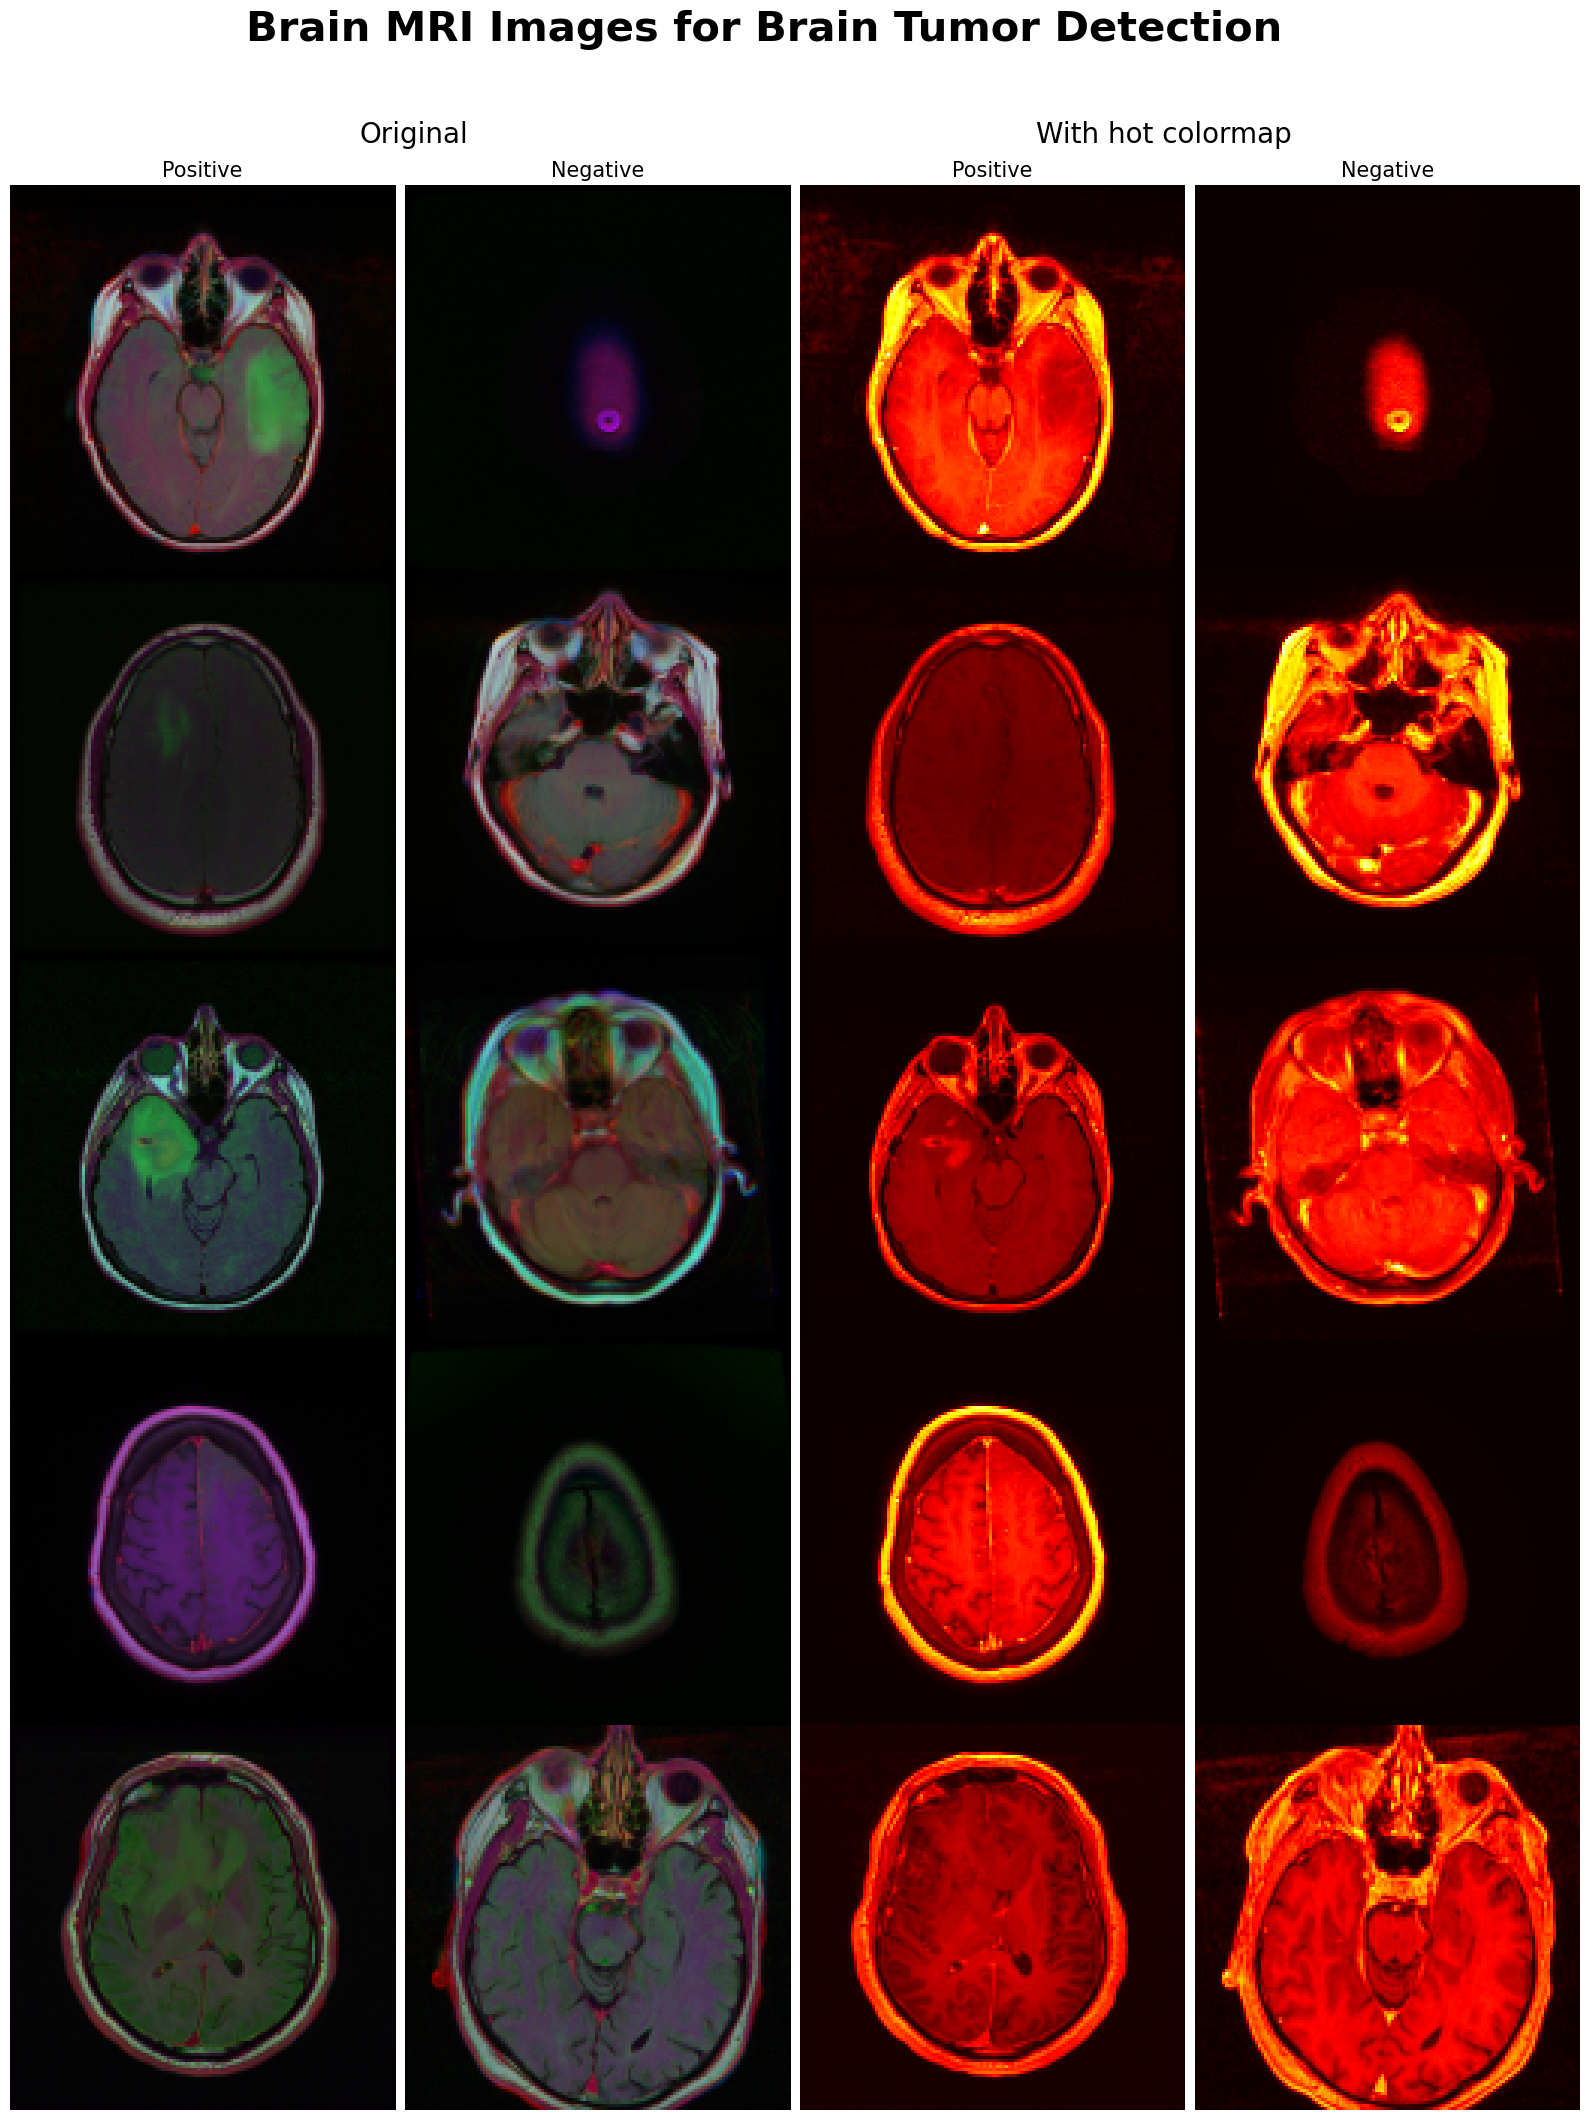

In [7]:
image_visual_samples = 5
sample_yes_df = df[df["diagnosis"] == 1].sample(image_visual_samples).image_path.values
sample_no_df = df[df["diagnosis"] == 0].sample(image_visual_samples).image_path.values

sample_imgs = []
for i, (yes, no) in enumerate(zip(sample_yes_df, sample_no_df)):
    yes = cv2.resize(cv2.imread(yes), (IMG_SIZE, IMG_SIZE))
    no = cv2.resize(cv2.imread(no), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([yes, no])

sample_yes_arr = np.vstack(np.array(sample_imgs[::2]))
sample_no_arr = np.vstack(np.array(sample_imgs[1::2]))

fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111, nrows_ncols=(1,4), axes_pad=0.1)

grid[0].imshow(sample_yes_arr)
grid[0].set_title("Positive", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_no_arr)
grid[1].set_title("Negative", fontsize=15)
grid[1].axis("off")

grid[2].imshow(sample_yes_arr[:,:,0], cmap="hot")
grid[2].set_title("Positive", fontsize=15)
grid[2].axis("off")
grid[3].imshow(sample_no_arr[:,:,0], cmap="hot")
grid[3].set_title("Negative", fontsize=15)
grid[3].axis("off")

# annotations
plt.figtext(0.36,0.90,"Original", va="center", ha="center", size=20)
plt.figtext(0.66,0.90,"With hot colormap", va="center", ha="center", size=20)
plt.suptitle("Brain MRI Images for Brain Tumor Detection", y=.95, fontsize=30, weight="bold")

# save and show
plt.savefig("dataset.png", bbox_inches='tight', pad_inches=0.2, transparent=True)
plt.show()

Text(0.5, 0.7, 'Sample with Positive Diagnosis')

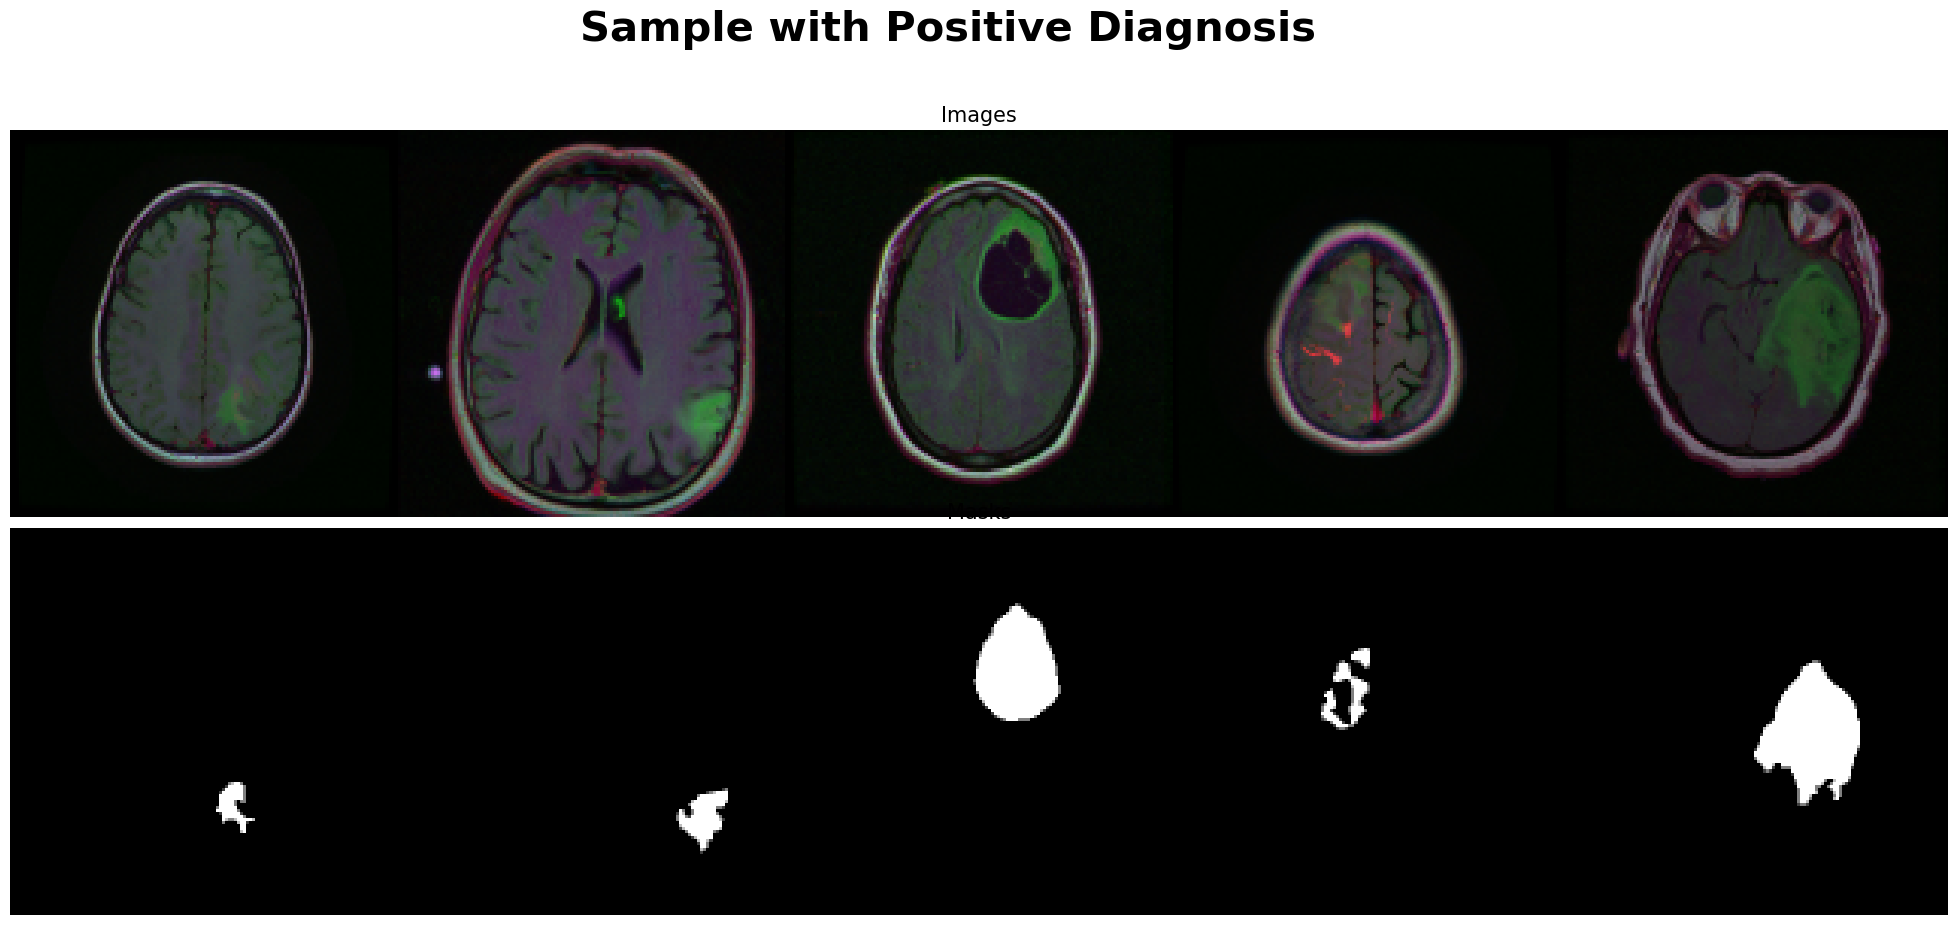

In [8]:
sample_df = df[df["diagnosis"] == 1].sample(5).values
sample_imgs = []

for i, data in enumerate(sample_df):
    img = cv2.resize(cv2.imread(data[1]), (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(cv2.imread(data[2]), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([img, mask])

sample_imgs_arr = np.hstack(np.array(sample_imgs[::2]))
sample_maps_arr = np.hstack(np.array(sample_imgs[1::2]))

fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111, nrows_ncols=(2,1), axes_pad=0.1)

grid[0].imshow(sample_imgs_arr)
grid[0].set_title("Images", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_maps_arr)
grid[1].set_title("Masks", fontsize=15)
grid[1].axis("off")


fig.suptitle("Sample with Positive Diagnosis", y=.70, fontsize=30, weight="bold")


In [9]:
brain_dataset = BrainDataset(DATA_PATH)
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(brain_dataset, [0.8, 0.2], generator=generator)
test_df = brain_dataset.get_test_df()

print(f"Train: {len(train_dataset)} \nVal: {len(val_dataset)}")

This is not a dir: ./dataset/lgg-mri-segmentation/kaggle_3m\data.csv
This is not a dir: ./dataset/lgg-mri-segmentation/kaggle_3m\README.md
Random Sample
Path to the Image: ./dataset/lgg-mri-segmentation/kaggle_3m\TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_3.tif 
Path to the Mask: ./dataset/lgg-mri-segmentation/kaggle_3m\TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_3_mask.tif
Train: 3049 
Val: 762


In [10]:
# Create Dataset Objects
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=4)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=4)

torch.Size([1, 3, 128, 128]) torch.Size([1, 1, 128, 128])


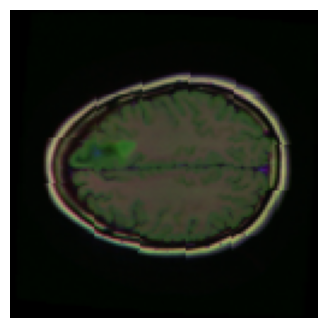

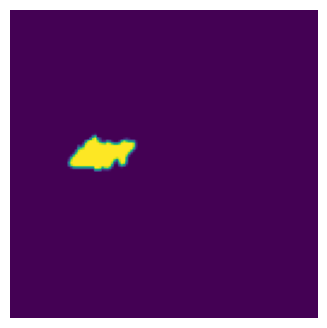

In [11]:
# Visualize Transformations

def show_aug(inputs, nrows=5, ncols=5, image=True):
    plt.figure(figsize=(20,20))
    plt.subplots_adjust(wspace=0., hspace=0.)

    i = 0

    if len(inputs) > 25:
        inputs = inputs[:25]
    
    for idx in range(len(inputs)):

        
        img = inputs[idx].numpy().transpose(1,2,0).astype(np.float32)
        img = img[:,:]
        

        plt.subplot(nrows, ncols, i+1)
        plt.imshow(img)
        plt.axis('off')

        i += 1
    
    return plt.show()



images, masks = next(iter(train_dataloader))
print(images.shape, masks.shape)

show_aug(images)
show_aug(masks, image = False)

# UNet_parts

In [12]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.conv_op(x)
    
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)
        
        return down, p

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], 1)
        return self.conv(x)

# UNet

In [13]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)
        
        self.bottle_neck = DoubleConv(512, 1024)
        
        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)
        
        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)
        
    def forward(self, x):
        down_1, p1 = self.down_convolution_1(x)
        down_2, p2 = self.down_convolution_2(p1)
        down_3, p3 = self.down_convolution_3(p2)
        down_4, p4 = self.down_convolution_4(p3)
        
        b = self.bottle_neck(p4)
        
        up_1 = self.up_convolution_1(b, down_4)
        up_2 = self.up_convolution_2(up_1, down_3)
        up_3 = self.up_convolution_3(up_2, down_2)
        up_4 = self.up_convolution_4(up_3, down_1)
        
        out = self.out(up_4)
        return out

        

# Training

In [14]:
if __name__ == "__main__":
    LEARNING_RATE = 3e-4
    EPOCHS = 10
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Device {device}")
    
    
    model = UNet(in_channels=3, num_classes=1).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.BCEWithLogitsLoss()
    
    for epoch in tqdm(range(EPOCHS)):
        model.train()
        train_running_loss = 0
        for idx, img_mask in enumerate(tqdm(train_dataloader)):
            img = img_mask[0].float().to(device)
            mask = img_mask[1].float().to(device)
            y_pred = model(img)
            optimizer.zero_grad() #LEARNTHIS
            
            loss = criterion(y_pred, mask)
            train_running_loss += loss.item()
            
            loss.backward() #LEARNTHIS
            optimizer.step() #LEARNTHIS
        
        train_loss = train_running_loss / idx + 1
        
        model.eval()
        val_running_loss = 0
        
        with torch.no_grad():
            for idx, img_mask in enumerate(tqdm(val_dataloader)):
                img = img_mask[0].float().to(device)
                mask = img_mask[1].float().to(device)

                y_pred = model(img)
                loss = criterion(y_pred, mask)
                
                val_running_loss = loss.item()
            
            val_loss = val_running_loss / idx + 1
        
        print("-"*30)
        print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
        print(f"Valid Loss EPOCH {epoch+1}: {val_loss:.4f}")
        print("-"*30)
    
    
    torch.save(model.state_dict(), MODEL_SAVE_PATH)

Device cuda


 10%|█         | 1/10 [13:36<2:02:29, 816.62s/it]

------------------------------
Train Loss EPOCH 1: 1.0479
Valid Loss EPOCH 1: 1.0000
------------------------------


 20%|██        | 2/10 [26:00<1:43:08, 773.56s/it]

------------------------------
Train Loss EPOCH 2: 1.0300
Valid Loss EPOCH 2: 1.0000
------------------------------


 30%|███       | 3/10 [36:48<1:23:34, 716.29s/it]

------------------------------
Train Loss EPOCH 3: 1.0280
Valid Loss EPOCH 3: 1.0000
------------------------------


 40%|████      | 4/10 [47:30<1:08:43, 687.19s/it]

------------------------------
Train Loss EPOCH 4: 1.0269
Valid Loss EPOCH 4: 1.0000
------------------------------


 50%|█████     | 5/10 [58:12<55:54, 670.84s/it]  

------------------------------
Train Loss EPOCH 5: 1.0264
Valid Loss EPOCH 5: 1.0002
------------------------------


 60%|██████    | 6/10 [1:09:02<44:14, 663.73s/it]

------------------------------
Train Loss EPOCH 6: 1.0260
Valid Loss EPOCH 6: 1.0001
------------------------------


 70%|███████   | 7/10 [1:47:41<1:00:15, 1205.01s/it]

------------------------------
Train Loss EPOCH 7: 1.0253
Valid Loss EPOCH 7: 1.0000
------------------------------


 80%|████████  | 8/10 [1:49:25<28:28, 854.41s/it]   

------------------------------
Train Loss EPOCH 8: 1.0242
Valid Loss EPOCH 8: 1.0001
------------------------------


 90%|█████████ | 9/10 [1:58:35<12:39, 759.20s/it]

------------------------------
Train Loss EPOCH 9: 1.0229
Valid Loss EPOCH 9: 1.0000
------------------------------


100%|██████████| 10/10 [2:17:40<00:00, 826.05s/it]


------------------------------
Train Loss EPOCH 10: 1.0219
Valid Loss EPOCH 10: 1.0000
------------------------------


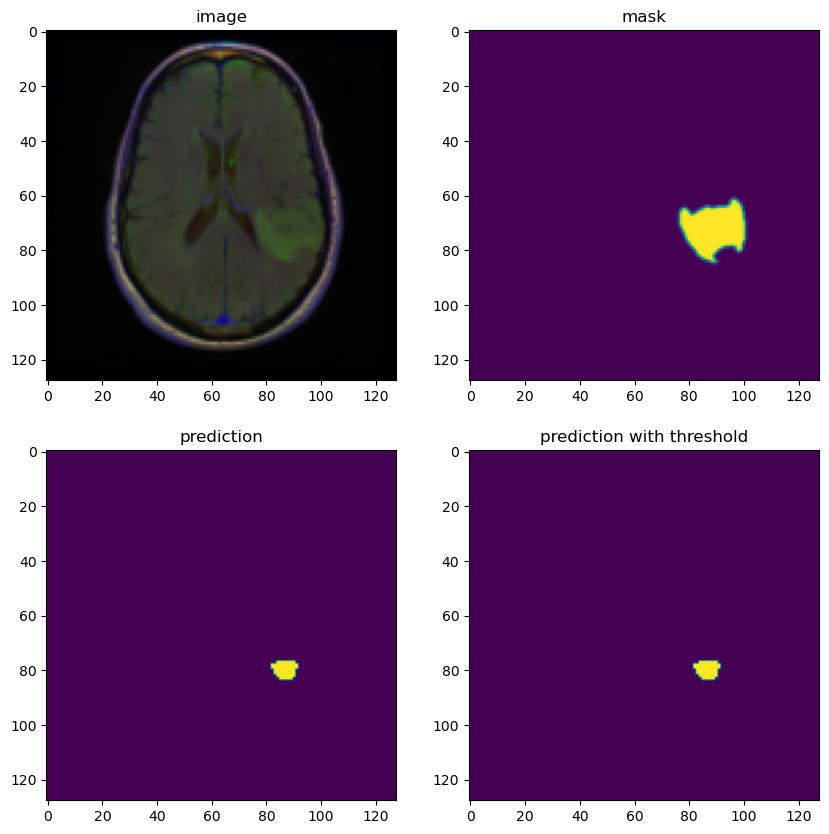

In [24]:
import matplotlib.pyplot as plt


def single_image_inference(image_pth, mask_pth):

    model = UNet(in_channels=3, num_classes=1).to(device)
    model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=torch.device(device)))

    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor()])

    img = transform(Image.open(image_pth)).float().to(device)
    img = img.unsqueeze(0)

    mask = transform(Image.open(mask_pth)).float()
    mask = mask.permute(1, 2, 0)
   
    pred_mask = model(img)

    img = img.squeeze(0).cpu().detach()
    img = img.permute(1, 2, 0)

    pred_mask = pred_mask.squeeze(0).cpu().detach()
    pred_mask = pred_mask.permute(1, 2, 0)
    pred_mask[pred_mask < 0]=0
    pred_mask[pred_mask > 0]=1

    pred_t = np.copy(pred_mask)
    pred_t[np.nonzero(pred_t < 0.3)] = 0.0
    pred_t[np.nonzero(pred_t >= 0.3)] = 255.
    pred_t = pred_t.astype("uint8")

   
    fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

    ax[0, 0].imshow(img)
    ax[0, 0].set_title("image")
    ax[0, 1].imshow(mask)
    ax[0, 1].set_title("mask")
    ax[1, 0].imshow(pred_mask)
    ax[1, 0].set_title("prediction")
    ax[1, 1].imshow(pred_t)
    ax[1, 1].set_title("prediction with threshold")
    plt.show()


if __name__ == "__main__":
    sample = test_df.sample(1).values[0]
    
    single_image_inference(sample[1], sample[2])

In [16]:
test_samples = test_df[test_df["diagnosis"] == 1].sample(30).values
print(len(test_samples))

def batch_preds_overlap(samples):
    
    model = UNet(in_channels=3, num_classes=1).to(device)
    model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=torch.device(device)))

    prediction_overlap = []
    
    for test_sample in samples:

        transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor()])

        img = transform(Image.open(test_sample[1])).float().to(device)
        img = img.unsqueeze(0)

        ground_truth = Image.open(test_sample[2])
        ground_truth = ground_truth.resize((IMG_SIZE, IMG_SIZE))
        ground_truth = ground_truth.convert('L')
        ground_truth = np.array(ground_truth).astype('uint8')
    
        pred_mask = model(img)

        img = img.squeeze(0).cpu().detach()
        img = img.permute(1, 2, 0)

        pred_mask = pred_mask.squeeze(0).cpu().detach()
        pred_mask = pred_mask.permute(1, 2, 0)
        pred_mask[pred_mask < 0]=0.0
        pred_mask[pred_mask > 0]=255.
        pred_mask = pred_mask.numpy()
        pred_mask = pred_mask.astype("uint8")


        original_img = transform(Image.open(test_sample[1])).float().to(device)

        original_img = Image.open(test_sample[1])
        original_img = original_img.resize((IMG_SIZE, IMG_SIZE))
        original_img = np.array(original_img).astype('uint8')

        _, thresh_gt = cv2.threshold(ground_truth, 127, 255, 0)
        _, thresh_p = cv2.threshold(pred_mask, 127, 255, 0)
        contours_gt, _ = cv2.findContours(thresh_gt, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours_p, _ = cv2.findContours(thresh_p, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        overlap_img = cv2.drawContours(original_img, contours_gt, 0, (0, 255, 0), 1)
        overlap_img = cv2.drawContours(overlap_img, contours_p, 0, (255,36,0), 1)
        prediction_overlap.append(overlap_img)

    return prediction_overlap
    
    
prediction_overlap_u = batch_preds_overlap(test_samples)

30


In [17]:
# unet plates
pred_overlap_5x1_u = []
pred_overlap_5x3_u = []

for i in range(5, 30+5, 5):
    pred_overlap_5x1_u.append(np.hstack(np.array(prediction_overlap_u[i-5:i])))

for i in range(3, 6+3, 3):
   pred_overlap_5x3_u.append(np.vstack(pred_overlap_5x1_u[i-3:i]))

In [18]:
# PLOT

def plot_plate_overlap(batch_preds, title, num):
    plt.figure(figsize=(15, 15))
    plt.imshow(batch_preds)
    plt.axis("off")

    plt.figtext(0.76,0.75,"Green - Ground Truth", va="center", ha="center", size=20,color="lime");
    plt.figtext(0.26,0.75,"Red - Prediction", va="center", ha="center", size=20, color="#ff0d00");
    plt.suptitle(title, y=.80, fontsize=20, weight="bold", color="#00FFDE");

    fn = "_".join((title+str(num)).lower().split()) + ".png"
    plt.savefig(fn, bbox_inches='tight', pad_inches=0.2, transparent=False, facecolor='black')
    plt.close()

    

title1 = "Predictions of Vanilla UNet"

for num, batch in enumerate(pred_overlap_5x3_u):
    plot_plate_overlap(batch,title1, num)
    


In [19]:
from PIL import Image

def make_gif(title):
    base_name = "_".join(title.lower().split())

    base_len = len(base_name) 
    end_len = len(".png")
    fp_in = f"{base_name}*.png"
    fp_out = f"{base_name}.gif"

    img, *imgs = [Image.open(f) 
                  for f in sorted(glob.glob(fp_in), 
                                  key=lambda x : int(x[base_len:-end_len]))]

    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=1000, loop=0)
    
    return fp_out

fn1 = make_gif(title1)

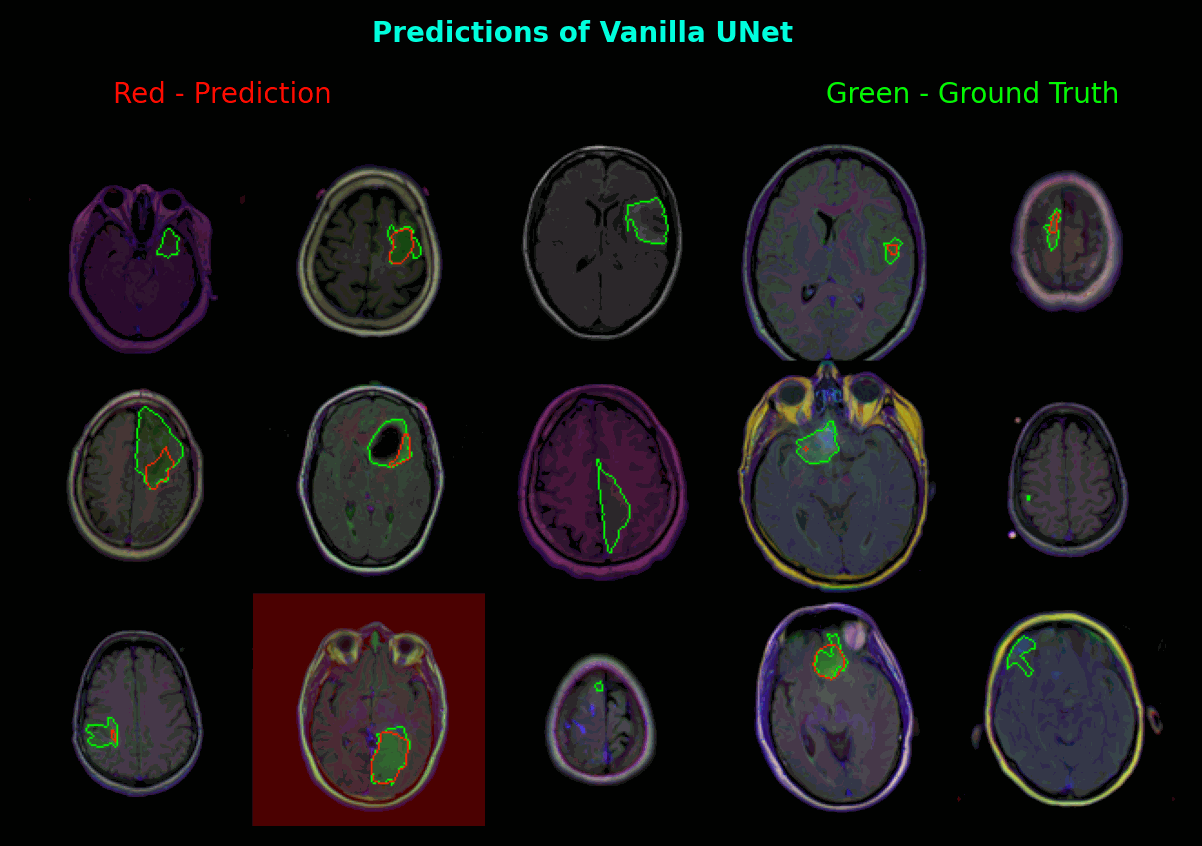

In [20]:
from IPython.display import Image as Image_display

with open(fn1,'rb') as f:
    display(Image_display(data=f.read(), format='png'))